/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 [Start] Flux 고품질 광고 생성 (Text Post-Processing Ver.)

🚀 [Phase 1] 누끼 작업 (BiRefNet)...


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)



🚀 [Phase 2] 배경 생성 (Flux 8-bit)...


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
  0%|          | 0/25 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 25/25 [01:03<00:00,  2.54s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.



🚀 [Phase 3] 객체 배치 (텍스트 없음)...

🚀 [Phase 4] Flux 통합 리터칭 (Visual Only)...


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
100%|██████████| 20/20 [00:49<00:00,  2.49s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.



🚀 [Phase 5] 최종 텍스트 합성 (Python)...


/tmp/ipykernel_5795/2119513433.py:50: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/2119513433.py:50: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/2119513433.py:50: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/2119513433.py:50: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/2119513433.py:50: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/2119513433.py:50: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/2119513433.py:50: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.

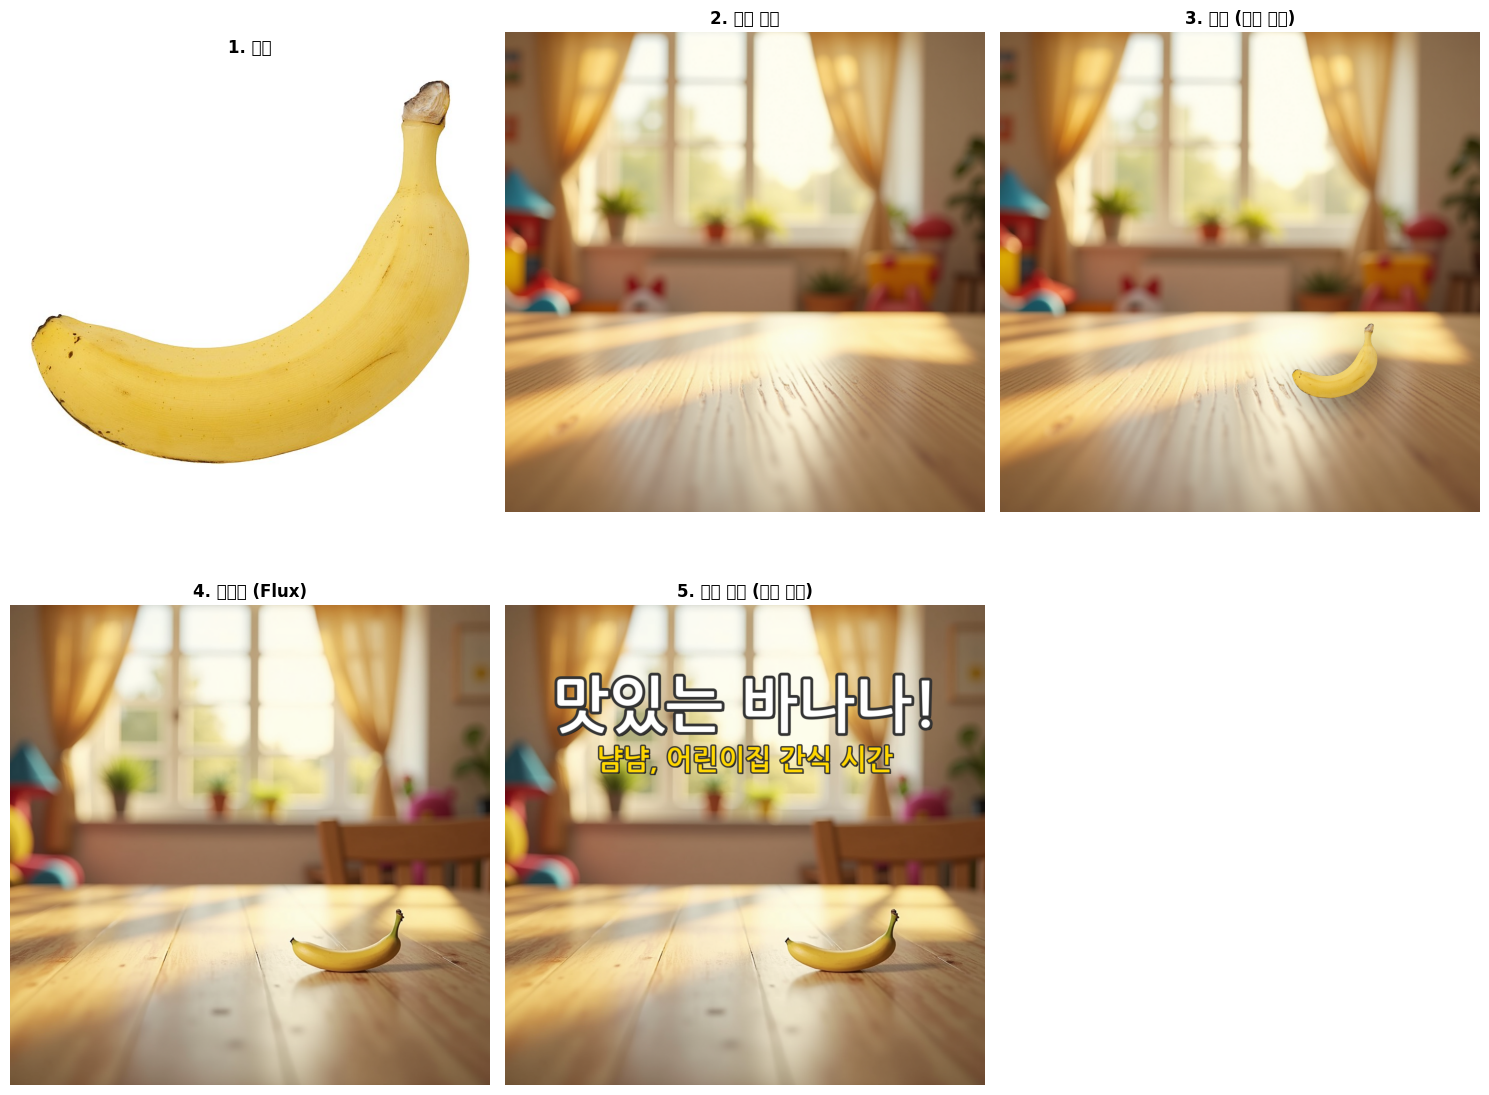

작업 완료: final_ad_clean_text.png


In [1]:
import torch
import gc
import os
import requests
import numpy as np
import math
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import FluxPipeline, FluxImg2ImgPipeline, FluxTransformer2DModel
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정 & 토큰
# ==========================================
# HF_TOKEN = "hf_..." # 여기에 토큰 입력
# login(token=HF_TOKEN)

DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def plot_steps(step_images):
    n = len(step_images)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(15, 6 * rows))
    for i, (img, title) in enumerate(step_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# [Phase 1] 누끼 (배경 제거)
# ==========================================
def run_segmentation(image_path):
    print("\n🚀 [Phase 1] 누끼 작업 (BiRefNet)...")
    flush()
    model = AutoModelForImageSegmentation.from_pretrained(MODEL_IDS["SEG"], trust_remote_code=True)
    model.to(DEVICE)
    model.eval()
    
    img = load_image(image_path).convert("RGB")
    W, H = img.size
    img_input = img.resize((1024, 1024), Image.LANCZOS)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(img_input).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = model(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 120 else 0)
    
    fg = img.copy()
    fg.putalpha(mask)
    
    del model, input_tensor
    flush()
    return img, fg, mask

# ==========================================
# [Phase 2] 배경 생성 (Flux 8-bit)
# ==========================================
def run_flux_bg():
    print("\n🚀 [Phase 2] 배경 생성 (Flux 8-bit)...")
    flush()
    
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"],
        subfolder="transformer",
        quantization_config=quant_config,
        torch_dtype=TORCH_DTYPE
    )
    
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"],
        transformer=transformer,
        torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    # 텍스트 관련 내용 제거, 배경 묘사에 집중
    prompt = (
        "A macro shot of a wooden table surface in a cozy bright daycare center. "
        "Blurred background with colorful toys, warm sunlight, soft bokeh, "
        "photorealistic, 8k resolution, cinematic lighting."
    )
    
    image = pipe(
        prompt,
        height=1024,
        width=1024,
        guidance_scale=3.5,
        num_inference_steps=25,
        max_sequence_length=512,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return image

# ==========================================
# [Phase 3] 객체 배치 (텍스트 제거됨 ❌)
# ==========================================
def run_composition_no_text(bg, fg, mask):
    print("\n🚀 [Phase 3] 객체 배치 (텍스트 없음)...")
    bg_w, bg_h = bg.size
    fg_w, fg_h = fg.size
    
    # 크기 및 위치 조정
    scale = 0.25 
    new_w, new_h = int(fg_w * scale), int(fg_h * scale)
    fg_resized = fg.resize((new_w, new_h), Image.LANCZOS)
    mask_resized = mask.resize((new_w, new_h), Image.LANCZOS)
    
    obj_x = int(bg_w * 0.6)
    obj_y = int(bg_h * 0.6)
    
    # 그림자 처리
    shadow = Image.new("RGBA", bg.size, (0,0,0,0))
    # 그림자를 약간 더 아래로 자연스럽게
    shadow.paste((0,0,0,120), (obj_x+10, obj_y+20), mask=mask_resized)
    shadow = shadow.filter(ImageFilter.GaussianBlur(30))
    
    # 합성
    comp = bg.convert("RGBA")
    comp = Image.alpha_composite(comp, shadow)
    
    fg_layer = Image.new("RGBA", bg.size, (0,0,0,0))
    fg_layer.paste(fg_resized, (obj_x, obj_y), mask=fg_resized)
    
    comp = Image.alpha_composite(comp, fg_layer)
    return comp.convert("RGB")

# ==========================================
# [Phase 4] 리터칭 (텍스트 프롬프트 제거 ❌)
# ==========================================
def run_flux_refinement_visual_only(composite_image):
    print("\n🚀 [Phase 4] Flux 통합 리터칭 (Visual Only)...")
    flush()
    
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"],
        subfolder="transformer",
        quantization_config=quant_config,
        torch_dtype=TORCH_DTYPE
    )
    
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"],
        transformer=transformer,
        torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    # 중요: 텍스트 관련 묘사를 모두 빼고 시각적 퀄리티에만 집중
    prompt = (
        "A photorealistic close-up shot. A cute chubby 5-year-old child's hand reaching out "
        "to grab a small yellow banana on a wooden table. "
        "Warm sunlight streaming, cinematic lighting, high quality, 8k, "
        "extremely detailed texture, depth of field."
    )
    
    # 텍스트가 없으므로 이미지가 망가질 확률이 줄어듦
    final = pipe(
        prompt=prompt,
        image=composite_image,
        strength=0.65, # 바나나 형태는 유지하되 손은 그려넣기 위함
        guidance_scale=3.5,
        num_inference_steps=30,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return final

# ==========================================
# [Phase 5] 최종 텍스트 합성 (New! ✨)
# ==========================================
def add_final_text_overlay(image):
    print("\n🚀 [Phase 5] 최종 텍스트 합성 (Python)...")
    draw = ImageDraw.Draw(image)
    W, H = image.size
    font_path = download_font()
    
    # 폰트 설정
    font_main = ImageFont.truetype(font_path, 130)
    font_sub = ImageFont.truetype(font_path, 60)
    
    text_main = "맛있는 바나나!"
    text_sub = "냠냠, 어린이집 간식 시간"
    
    # 텍스트 위치 계산 함수
    def get_centered_pos(text, font, y_pos):
        bbox = draw.textbbox((0, 0), text, font=font)
        text_w = bbox[2] - bbox[0]
        x_pos = (W - text_w) // 2
        return x_pos, y_pos

    # 1. 메인 텍스트 (흰색 + 진한 외곽선)
    x1, y1 = get_centered_pos(text_main, font_main, 150)
    # 그림자 효과 (가독성 UP)
    draw.text((x1+5, y1+5), text_main, font=font_main, fill=(0,0,0,100)) 
    # 외곽선
    draw.text((x1, y1), text_main, font=font_main, fill="white", stroke_width=6, stroke_fill="#333")
    
    # 2. 서브 텍스트 (노란색 + 얇은 외곽선)
    x2, y2 = get_centered_pos(text_sub, font_sub, 300)
    draw.text((x2+3, y2+3), text_sub, font=font_sub, fill=(0,0,0,100))
    draw.text((x2, y2), text_sub, font=font_sub, fill="#FFD700", stroke_width=3, stroke_fill="#333")
    
    return image

# ==========================================
# 메인 실행
# ==========================================
def process_flux_ad_final(image_path):
    print("🔥 [Start] Flux 고품질 광고 생성 (Text Post-Processing Ver.)")
    step_images = []
    
    # 1. 누끼
    orig, fg, mask = run_segmentation(image_path)
    step_images.append((orig, "1. 원본"))
    
    # 2. 배경 생성
    bg = run_flux_bg()
    step_images.append((bg, "2. 배경 생성"))
    
    # 3. 객체 배치 (글자 X)
    draft_no_text = run_composition_no_text(bg, fg, mask)
    step_images.append((draft_no_text, "3. 배치 (글자 없음)"))
    
    # 4. 리터칭 (자연스러운 합성 & 아이 손 추가)
    refined = run_flux_refinement_visual_only(draft_no_text)
    step_images.append((refined, "4. 리터칭 (Flux)"))
    
    # 5. 글자 합성 (최종)
    final_result = add_final_text_overlay(refined.copy()) # 원본 보존을 위해 copy
    step_images.append((final_result, "5. 최종 완성 (글자 합성)"))
    
    final_result.save("final_ad_clean_text.png")
    plot_steps(step_images)
    print("작업 완료: final_ad_clean_text.png")

# 실행
process_flux_ad_final("image.png")